In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/F2BMLD")
import matplotlib.cm as cm
import matplotlib
import sys
sys.path.append("/home/zongchen/F2BMLD")
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Sequence, Tuple
from functools import partial
from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=16, labelsize=18, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [2]:
import gymnasium as gym
from methods import dfiv, f2bmld
import utils
from utils import load_pretrained_dqn
env = gym.make("CartPole-v1")

env_spec = {
        "obs_dim": 4,
        "act_dim": 2,
        "obs_space": env.observation_space,
        "act_space": env.action_space,
    }

value_layer_sizes = "50, 50"
instrumental_layer_sizes= "50, 50"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

value_func, instrumental_feature = dfiv.bsuite_network.make_value_func_bsuite(
    env_spec, value_layer_sizes, instrumental_layer_sizes, device
)

treatment_net = f2bmld.bsuite_network.TreatmentNetwork(env_spec, layer_sizes=[50, 1]).to(device)

def target_policy(obs_batch: torch.Tensor, policy_dqn: torch.nn.Module, epsilon) -> torch.Tensor:
    """
    Policy that follows the trained DQN policy but with probability epsilon takes a random action.
    """
    with torch.no_grad():
        greedy_actions = policy_dqn(obs_batch).argmax(dim=-1)  # [batch]
    
    random_mask = torch.rand(len(obs_batch)) < epsilon
    random_actions = torch.randint(0, 2, size=(len(obs_batch),), dtype=torch.long).to(obs_batch.device)
    final_actions = greedy_actions.clone()
    final_actions[random_mask] = random_actions[random_mask]
    return final_actions

class RandomActionWrapper(gym.Wrapper):
    """With probability `eps`, take a random action instead of the policy's action."""
    def __init__(self, env, eps=0.1):
        super().__init__(env)
        self.eps = eps

    def step(self, action):
        if np.random.rand() < self.eps:
            action = self.env.action_space.sample()
        return self.env.step(action)

In [3]:
def eval(environment, policy, value_func, num_init_samples, device):
    q0s = []
    for _ in tqdm(range(num_init_samples)):
        obs, _ = environment.reset()
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        action = policy(obs_tensor)
        q0 = value_func(obs_tensor, action).item()
        q0s.append(q0)

    q0s = np.array(q0s)
    return q0s.mean()


def estimate_true_value(policy, environment, discount=0.99, 
                        num_episodes=100, device="cpu"):
    """
    Estimate the true discounted return of a policy by Monte Carlo rollouts.

    Args:
        policy: Callable/nn.Module mapping obs -> action (PyTorch).
        environment: Gym-like env with reset() and step().
        discount: float, discount factor.
        num_episodes: int, number of episodes to average over.
        device: str, "cpu" or "cuda".

    Returns:
        mean_return: average discounted return across episodes.
        stderr_return: standard error of returns.
    """
    returns = []
    for _ in tqdm(range(num_episodes)):
        obs, _ = environment.reset()
        done, ep_return, t = False, 0.0, 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            action = policy(obs_tensor)

            # handle discrete vs continuous
            if isinstance(action, torch.Tensor):
                if action.numel() == 1:  # discrete scalar
                    action = int(action.item())
                else:  # e.g. policy outputs logits/probs
                    action = int(torch.argmax(action, dim=-1).item())

            next_obs, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            ep_return += (discount ** t) * reward
            obs = next_obs
            t += 1

        returns.append(ep_return)

    mean_return = float(np.mean(returns))
    return mean_return, float(np.std(returns)) / np.sqrt(num_episodes)

In [ ]:
seed_list = [0, 1, 2, 3, 4]
env_noise_list = [0.0, 0.1, 0.2, 0.3, 0.4]
policy_noise_list = [0.0]
# reg = "0.0001"
reg = "1e-05"
lag = 0.3

f2bmld_dict = {env_noise: np.array([0.] * len(seed_list)) for env_noise in env_noise_list}

bs_dict = {0.0: 1024, 0.1: 32, 0.2: 32, 0.3: 32, 0.4: 32, 0.5: 32}

for env_noise in env_noise_list:
    for policy_noise in policy_noise_list:
        policy_dqn = load_pretrained_dqn(f"pretrained_dqns/policy_net_{env_noise}.pth", device)
        if env_noise > 0.0:
                environment = RandomActionWrapper(env, eps=env_noise)
        else:
            environment = env
        truth_value, truth_value_ste = estimate_true_value(
            partial(target_policy, policy_dqn=policy_dqn, epsilon=policy_noise), environment, discount=0.99, num_episodes=100, device=device
        )
        for seed in seed_list:
            ### F2BMLD
            path = f"/home/zongchen/F2BMLD/results/f2bmld_env_noise_{env_noise}__policy_noise_{policy_noise}"
            path += f"__lagrange_{lag}__stage1_reg_{reg}__stage2_reg_{reg}__treat_lr_0.001"
            path += f"__instr_lr_0.001__instr_iter_10__instr_tilde_iter_10__bs_{bs_dict[env_noise]}__seed_{seed}/treatment_net.pth"
            treatment_net.load_state_dict(torch.load(path, map_location=device))

            estimate_value = eval(environment, partial(target_policy, policy_dqn=policy_dqn, epsilon=policy_noise), treatment_net, 
                                    num_init_samples=1000, device=device)

            # print(truth_value, truth_value_ste)
            # print(estimate_value)
            
            f2bmld_dict[env_noise][seed] = np.abs(estimate_value - truth_value)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/zongchen/F2BMLD/results/f2bmld_env_noise_0.1__policy_noise_0.0__lagrange_0.3__stage1_reg_1e-05__stage2_reg_1e-05__treat_lr_0.001__instr_lr_0.001__instr_iter_10__instr_tilde_iter_10__bs_1024__seed_0/treatment_net.pth'

In [ ]:
seed_list = [0, 1, 2, 3, 4]
env_noise_list = [0.0, 0.1, 0.2, 0.3, 0.4]
policy_noise_list = [0.0]
# reg = "0.0001"
reg = "1e-05"
lag = 0.3

dfiv_dict = {env_noise: np.array([0.] * len(seed_list)) for env_noise in env_noise_list}


for env_noise in env_noise_list:
    for policy_noise in policy_noise_list:
        policy_dqn = load_pretrained_dqn(f"pretrained_dqns/policy_net_{env_noise}.pth", device)
        if env_noise > 0.0:
                environment = RandomActionWrapper(env, eps=env_noise)
        else:
            environment = env
        truth_value, truth_value_ste = estimate_true_value(
            partial(target_policy, policy_dqn=policy_dqn, epsilon=policy_noise), environment, discount=0.99, num_episodes=100, device=device
        )
        for seed in seed_list:
            ### DFIV
            path = f"/home/zongchen/F2BMLD/results/dfiv_env_noise_{env_noise}__policy_noise_{policy_noise}"
            path += f"_seed_{seed}/value_func.pth"
            value_func.load_state_dict(torch.load(path, map_location=device))

            estimate_value = eval(environment, partial(target_policy, policy_dqn=policy_dqn, epsilon=policy_noise), value_func, 
                                    num_init_samples=1000, device=device)

            # print(truth_value, truth_value_ste)
            # print(estimate_value)

            dfiv_dict[env_noise][seed] = np.abs(estimate_value - truth_value)
            

100%|██████████| 1000/1000 [00:00<00:00, 2554.22it/s]


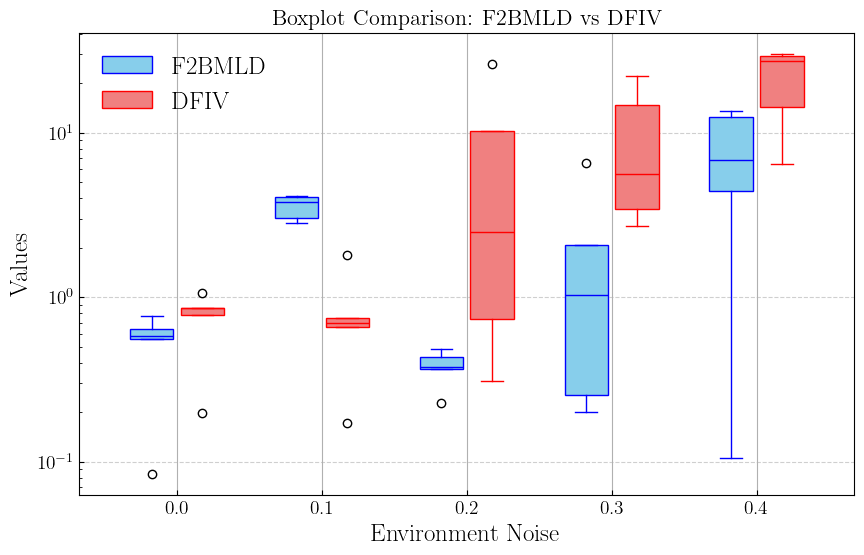

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
labels = list(f2bmld_dict.keys())
data_f2bmld = [f2bmld_dict[key] for key in labels]
data_dfiv = [dfiv_dict[key] for key in labels]

# Positions for boxplots
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))

# Boxplots side-by-side
bp1 = plt.boxplot(data_f2bmld, positions=x - width/2, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor="skyblue", color="blue"),
                  medianprops=dict(color="blue"),
                  whiskerprops=dict(color="blue"),
                  capprops=dict(color="blue"))

bp2 = plt.boxplot(data_dfiv, positions=x + width/2, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor="lightcoral", color="red"),
                  medianprops=dict(color="red"),
                  whiskerprops=dict(color="red"),
                  capprops=dict(color="red"))

# X-axis labels
plt.xticks(x, labels)

plt.xlabel("Environment Noise")
plt.ylabel("Absolute Error")
plt.yscale("log")
plt.title("Offline Policy Evaluation")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Add legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["F2BMLD", "DFIV"], loc="upper left")

plt.show()


In [ ]:
dfiv_dict[env_noise]

array([29.37890142,  6.42893196, 27.41921717, 14.30792134, 30.04547866])

In [ ]:
np.abs(estimate_value - truth_value)

np.float64(30.045478659977064)